In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import models.linear as linears
import control.agents as agents
import control.environments as env

In [8]:
from utils.notifications import Slack

In [9]:
import copy

# Setup

In [10]:
environment = env.OverSimplifiedEnvironment(
    environment=gym.make('Breakout-ram-v0'), 
    agent=None,
    verbose=True,
    max_steps=200,
    capacity=5000,
    representation_method='mixed',
    mixed_threshold=10,
    max_tiling=5
)

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [11]:
input_dimension = environment.get_input_dimension()
n_actions = environment.n_actions
print("Input dimension: {}; number of actions: {}".format(input_dimension, n_actions))

Input dimension: 986; number of actions: 3


In [12]:
model = mlps.MLP(input_dimension=input_dimension, 
                 hidden_dimension=400,
                 n_hidden_layers=2,
                 n_actions=n_actions,
                 dropout=.3)
optimiser = torch.optim.Adam(model.parameters(), lr=.001)
agent = agents.DQNAgent(model, optimiser, gamma=.999, temperature=10, algorithm='expsarsa', n_actions=n_actions)
environment.agent = agent

In [14]:
print(environment.agent.q(environment.state_representation(environment.environment.reset())))
model.load_state_dict(torch.load('../saved/mixed_mlp/state_dict.pth'))
agent.commit()
print(environment.agent.q(environment.state_representation(environment.environment.reset())))

[ 0.00535929  0.03451415 -0.03420346]
[-0.0968741   0.00122213 -0.05829813]


# Experiment

## Training

100%|###############################################################| 10/10 [10:20<00:00, 61.76s/it]


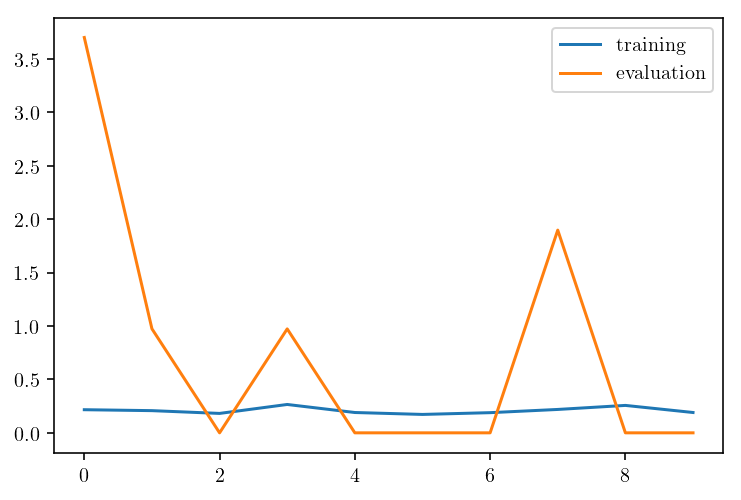

100%|###############################################################| 10/10 [18:53<00:00, 74.02s/it]


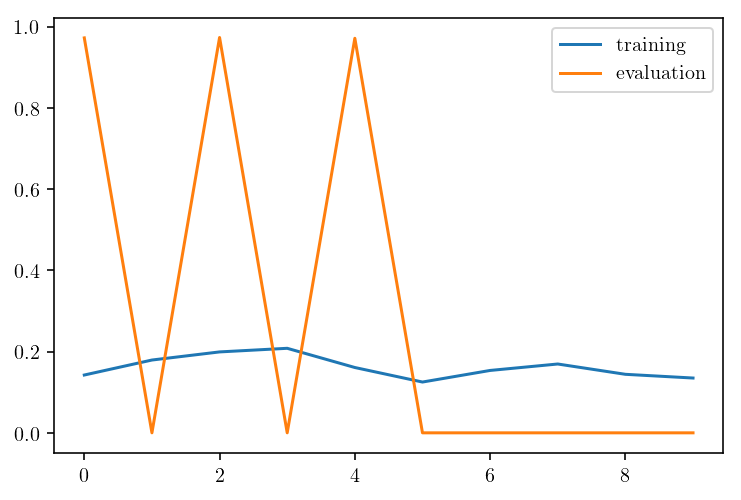

100%|###############################################################| 10/10 [10:55<00:00, 64.39s/it]


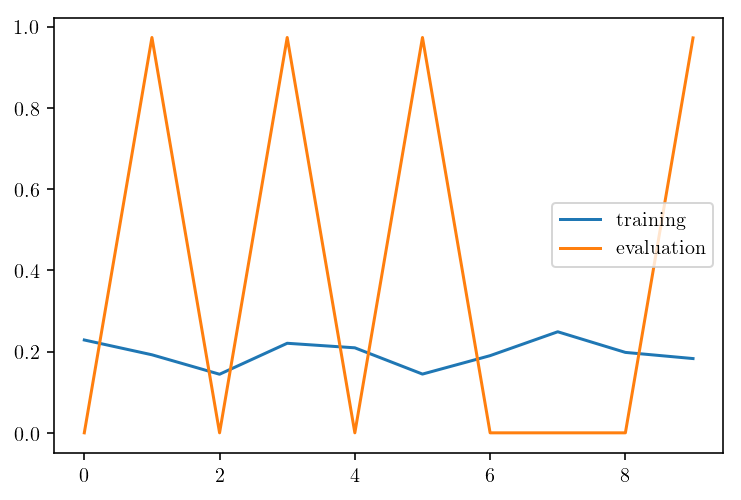

100%|###############################################################| 10/10 [10:35<00:00, 62.90s/it]


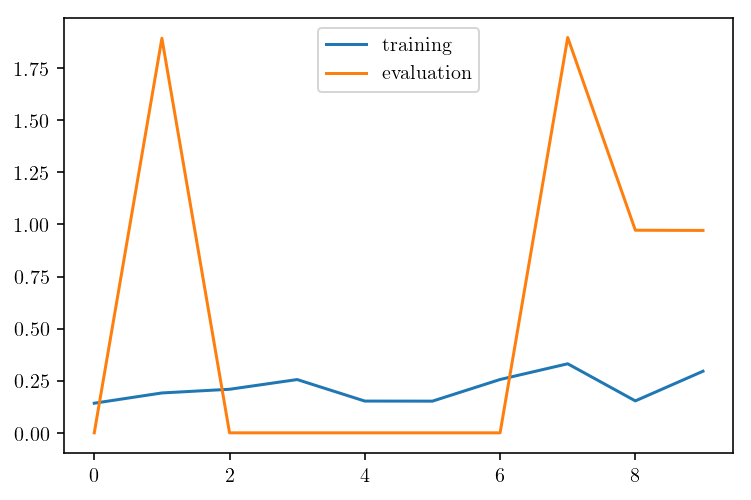

100%|###############################################################| 10/10 [10:38<00:00, 63.06s/it]


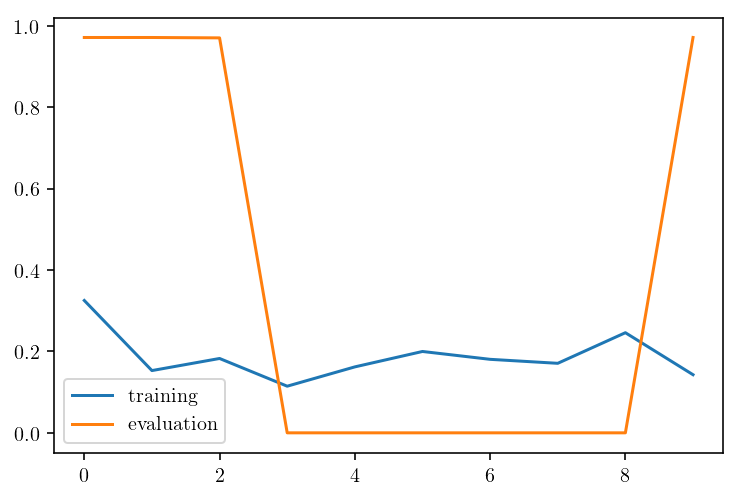

100%|###############################################################| 10/10 [11:07<00:00, 69.99s/it]


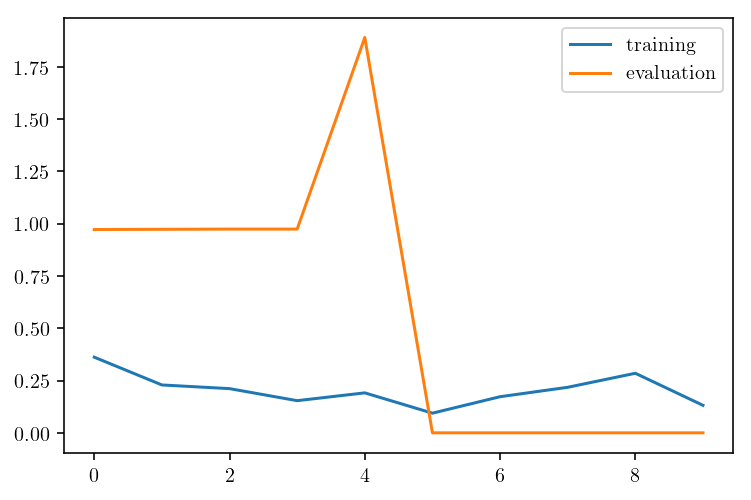

  0%|                                                                        | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [42]:
agent.commit()
agent.temperature = 1
returns_train = []
returns_eval = []
q_estimation = []

for _ in range(10):
    
    returns = environment.train(segments=10, episodes=100)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    agent.temperature *= .8
    
    returns_train.append(np.mean(returns.T[0]))
    returns_eval.append(np.mean(returns.T[1]))

    q_estimation.append(environment.agent.q(environment.state_representation(environment.environment.reset())))

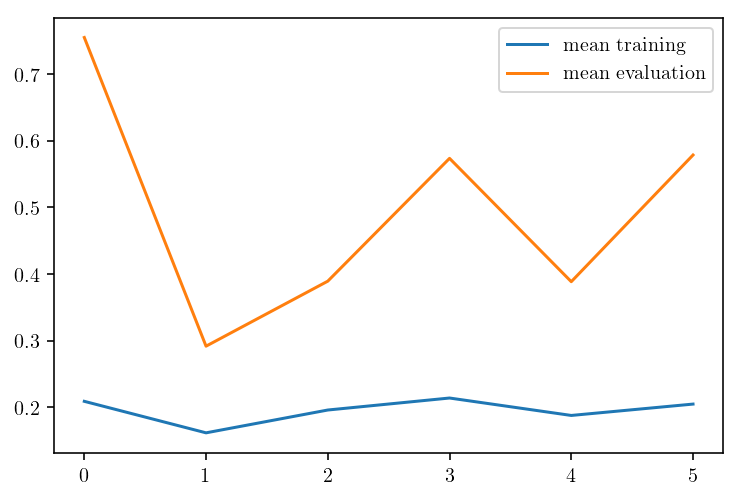

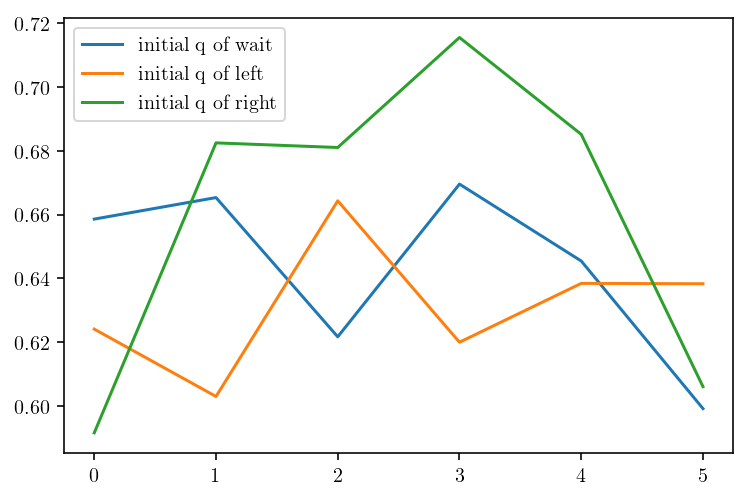

In [43]:
plt.figure()
plt.plot(returns_train, label='mean training')
plt.plot(returns_eval, label='mean evaluation')
plt.legend()
plt.show()

q_estimation = np.asarray(q_estimation)
plt.figure()
plt.plot(q_estimation[:, 0], label='initial q of wait')
plt.plot(q_estimation[:, 1], label='initial q of left')
plt.plot(q_estimation[:, 2], label='initial q of right')
plt.legend()
plt.show()

## Testing

In [39]:
for _ in range(5):
    environment.exploration_episode(render=True)

In [40]:
for _ in range(5):
    environment.evaluation_episode(render=True)

## Save

In [41]:
environment.agent.save('../saved/mixed_mlp')